## 0. Import Libraries

In [4]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import matplotlib
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy 

import warnings
warnings.filterwarnings('ignore')

## 1. Open Data

### 1.1 ERA5

#### 1.1.1 theta_e

In [3]:
run_data = 'era5'
variable = 'theta_e'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]
cs_time = 0

In [30]:
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}**cs1*')

# open data
dt_theta_era5 = xr.open_mfdataset(data_path,
                       concat_dim='ens')[variable]

# ensemble member list
ensemble_members = list(dt_theta_era5.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_theta_era5_urban_ens = dt_theta_era5.sel(ens=urban_members).mean(dim='ens')
dt_theta_era5_nourban_ens = dt_theta_era5.sel(ens=nourban_members).mean(dim='ens')
dt_theta_era5_diff = dt_theta_era5_urban_ens - dt_theta_era5_nourban_ens

In [31]:
# cs2
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}**cs2*')

# open data
dt_theta_era5 = xr.open_mfdataset(data_path,
                       concat_dim='ens')[variable]

# ensemble member list
ensemble_members = list(dt_theta_era5.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_theta_era5_urban_ens_cs2 = dt_theta_era5.sel(ens=urban_members).mean(dim='ens')
dt_theta_era5_nourban_ens_cs2 = dt_theta_era5.sel(ens=nourban_members).mean(dim='ens')
dt_theta_era5_diff_cs2 = dt_theta_era5_urban_ens_cs2 - dt_theta_era5_nourban_ens_cs2

#### 1.1.2 wa

In [5]:
run_data = 'era5'
variable = 'wa'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

In [6]:
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}**cs1*')

# open data
dt_wa_era5 = xr.open_mfdataset(data_path,
                       concat_dim='ens')[variable]

# ensemble member list
ensemble_members = list(dt_wa_era5.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_wa_era5_urban_ens = dt_wa_era5.sel(ens=urban_members).mean(dim='ens')
dt_wa_era5_nourban_ens = dt_wa_era5.sel(ens=nourban_members).mean(dim='ens')
dt_wa_era5_diff = dt_wa_era5_urban_ens - dt_wa_era5_nourban_ens

In [7]:
data_path

['data/era5_LIN_nourban_wa_wrfout_d03_2017-07-18_cs1.nc',
 'data/era5_LIN_urban_wa_wrfout_d03_2017-07-18_cs1.nc',
 'data/era5_THOMPSON_nourban_wa_wrfout_d03_2017-07-18_cs1.nc',
 'data/era5_THOMPSON_urban_wa_wrfout_d03_2017-07-18_cs1.nc',
 'data/era5_WSM6_nourban_wa_wrfout_d03_2017-07-18_cs1.nc',
 'data/era5_WSM6_urban_wa_wrfout_d03_2017-07-18_cs1.nc']

In [8]:
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}**cs2*')

# open data
dt_wa_era5 = xr.open_mfdataset(data_path,
                       concat_dim='ens')[variable]

# ensemble member list
ensemble_members = list(dt_wa_era5.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_wa_era5_urban_ens_cs2 = dt_wa_era5.sel(ens=urban_members).mean(dim='ens')
dt_wa_era5_nourban_ens_cs2 = dt_wa_era5.sel(ens=nourban_members).mean(dim='ens')
dt_wa_era5_diff_cs2 = dt_wa_era5_urban_ens_cs2 - dt_wa_era5_nourban_ens_cs2

#### 1.1.3 QVAPOR

In [11]:
run_data = 'era5'
variable = 'QVAPOR'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

In [12]:
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}**cs1*')

# open data
dt_qv_era5 = xr.open_mfdataset(data_path,
                       concat_dim='ens')[variable]

# ensemble member list
ensemble_members = list(dt_qv_era5.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_qv_era5_urban_ens = dt_qv_era5.sel(ens=urban_members).mean(dim='ens')
dt_qv_era5_nourban_ens = dt_qv_era5.sel(ens=nourban_members).mean(dim='ens')
dt_qv_era5_diff = dt_qv_era5_urban_ens - dt_qv_era5_nourban_ens

In [13]:
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}**cs2*')

# open data
dt_qv_era5 = xr.open_mfdataset(data_path,
                       concat_dim='ens')[variable]

# ensemble member list
ensemble_members = list(dt_qv_era5.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_qv_era5_urban_ens_cs2 = dt_qv_era5.sel(ens=urban_members).mean(dim='ens')
dt_qv_era5_nourban_ens_cs2 = dt_qv_era5.sel(ens=nourban_members).mean(dim='ens')
dt_qv_era5_diff_cs2 = dt_qv_era5_urban_ens_cs2 - dt_qv_era5_nourban_ens_cs2

In [14]:
bottom_hgt_list = []
dt_tempor = dt_qv_era5_diff[0]
for i in range(len(dt_tempor['cross_line_idx'])):
    
    bottom_hgt_list.append(float(dt_tempor.sel(cross_line_idx=i).dropna(dim='vertical')[0]['vertical'].values))

In [15]:
bottom_hgt_list_cs2 = []
dt_tempor_cs2 = dt_qv_era5_diff_cs2[0]
for i in range(len(dt_tempor['cross_line_idx'])):
    
    bottom_hgt_list_cs2.append(float(dt_tempor_cs2.sel(cross_line_idx=i).dropna(dim='vertical')[0]['vertical'].values))

## 2. Hourly Figure

### 2.1 Theta_e and wa options

In [16]:
# Parameters to change (plot) -------------------
cmap = proplot.Colormap('ColdHot')

# fig features
fig_array = [[1, 2, 3, 4],
             [5, 6, 7, 8]
            ]
graphic_no = 8

# graphic vmin, vmax and norms

clevs_total = np.arange(-14, 14.1, 2)
norm = BoundaryNorm(clevs_total,
                    ncolors=cmap.N, 
                    clip=True)
ticks = np.arange(-14, 14.1, 7)

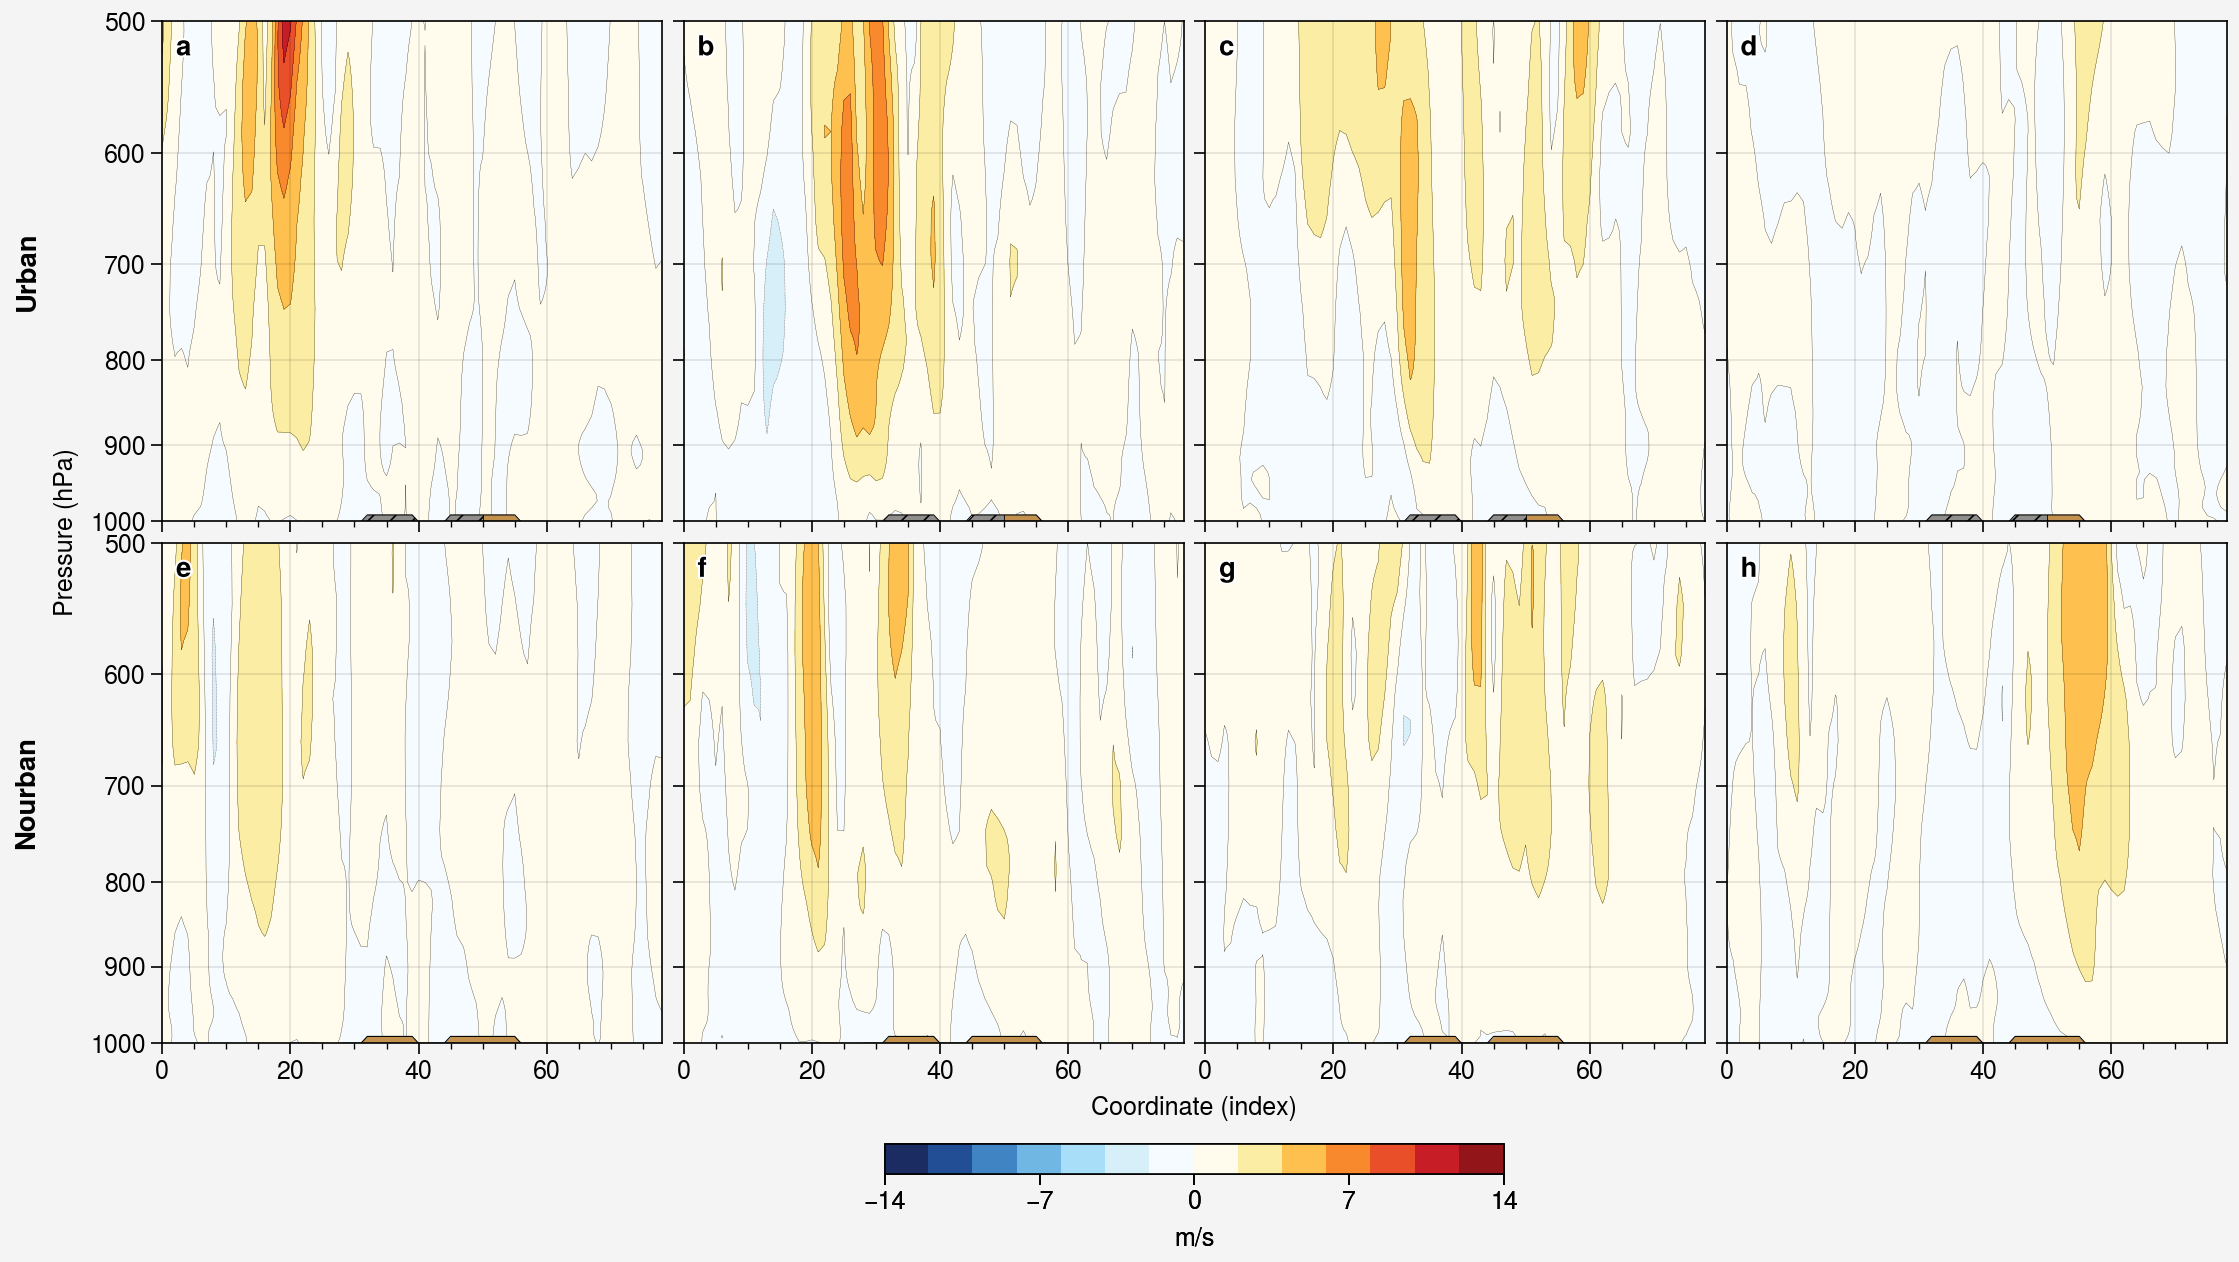

In [17]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            
                            includepanels=True,
                            hspace=0.86,
                            wspace=0.86,
                            sharey=3)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

axs.format(rowlabels=['Urban', 'Nourban'],
           #collabels=['11UTC', '12UTC', '13UTC', '14UTC']
           )

axs.format(ylim=(1000, 500), yscale='log',
           ylabel='Pressure (hPa)', ylocator=100,
           xlabel='Coordinate (index)')

x_fill = [20, 30, 40, 50]
y_fill = [800, 800, 800, 800]

for t in range(graphic_no):
    
    if t < graphic_no/2:
        dt_ens = dt_wa_era5_urban_ens
        #dt_ens_theta = dt_theta_era5_urban_ens
        
        i = t
    else:
        dt_ens = dt_wa_era5_nourban_ens
        #dt_ens_theta = dt_theta_era5_nourban_ens
        
        i = t-int(graphic_no/2)
        
    cut = -0.05
    mesh = axs[t].contourf(dt_ens[i]['cross_line_idx'], 
                    dt_ens[i]['vertical'],#[::-1],
                    dt_ens[i], 
                    cmap = cmap,
                    cmap_kw={'cut': cut},
                    linewidth = 0.1,
                    norm=norm,
                    zorder = 0.2,
                    alpha=1)
    
    contour_levels = np.array([320, 322, 324, 326, 328, 330,
                               332, 334, 336, 338, 340, 346, 352,
                               358, 364])
    
    #contour = axs[t].contour(dt_ens_theta[i]['cross_line_idx'], 
    #                dt_ens_theta[i]['vertical'],#[::-1],
    #                dt_ens_theta[i], 
    #                levels = contour_levels,
    #                zorder = 0.3,
    #                alpha=0.8,
    #               colors='black',
    #               labels=True,
    #               lw = 0.6)
    
    axs[t].set_facecolor("#c1914d")
    
    if t < graphic_no/2:
        axs[t].fill_between(x_fill, 1000, y_fill,
                            interpolate=True, zorder=0.1,
                            color='#8f8e8c', hatch="///",
                            edgecolor="k", lw=0.3)
    
    # bottom hgt line
    axs[t].plot(range(len(dt_ens['cross_line_idx'])),
                 bottom_hgt_list,
                 color='k',
                 lw=0.4)
    
# colorbar
cbar = fig.colorbar(mesh,
                    label='m/s',
                    ticks = ticks,
                    loc = 'b',
                    shrink = 0.3,
                    width = 0.15
                    #col=2
                   )

#save figure
#plt.savefig(r'pictures/era5_cs_thetae_wa_hourly.jpeg',
#            bbox_inches='tight', optimize=True,
#            progressive=True, dpi=1000)

### 2.2 qvapor option

In [23]:
# Parameters to change (plot) -------------------
cmap = proplot.Colormap('batlow_r')

# fig features
fig_array = [[1, 2, 3, 4],
             [5, 6, 7, 8]
            ]
graphic_no = 8

# graphic vmin, vmax and norms

clevs_total = np.array([0,2,4,6,8,9,10,11,12,12.5,13,13.5,14,14.5,15])
norm = BoundaryNorm(clevs_total,
                    ncolors=cmap.N, 
                    clip=True)
ticks = np.array([0,4,8,10,12,13,14,15])

NameError: name 'dt_avo_era5_urban_ens' is not defined

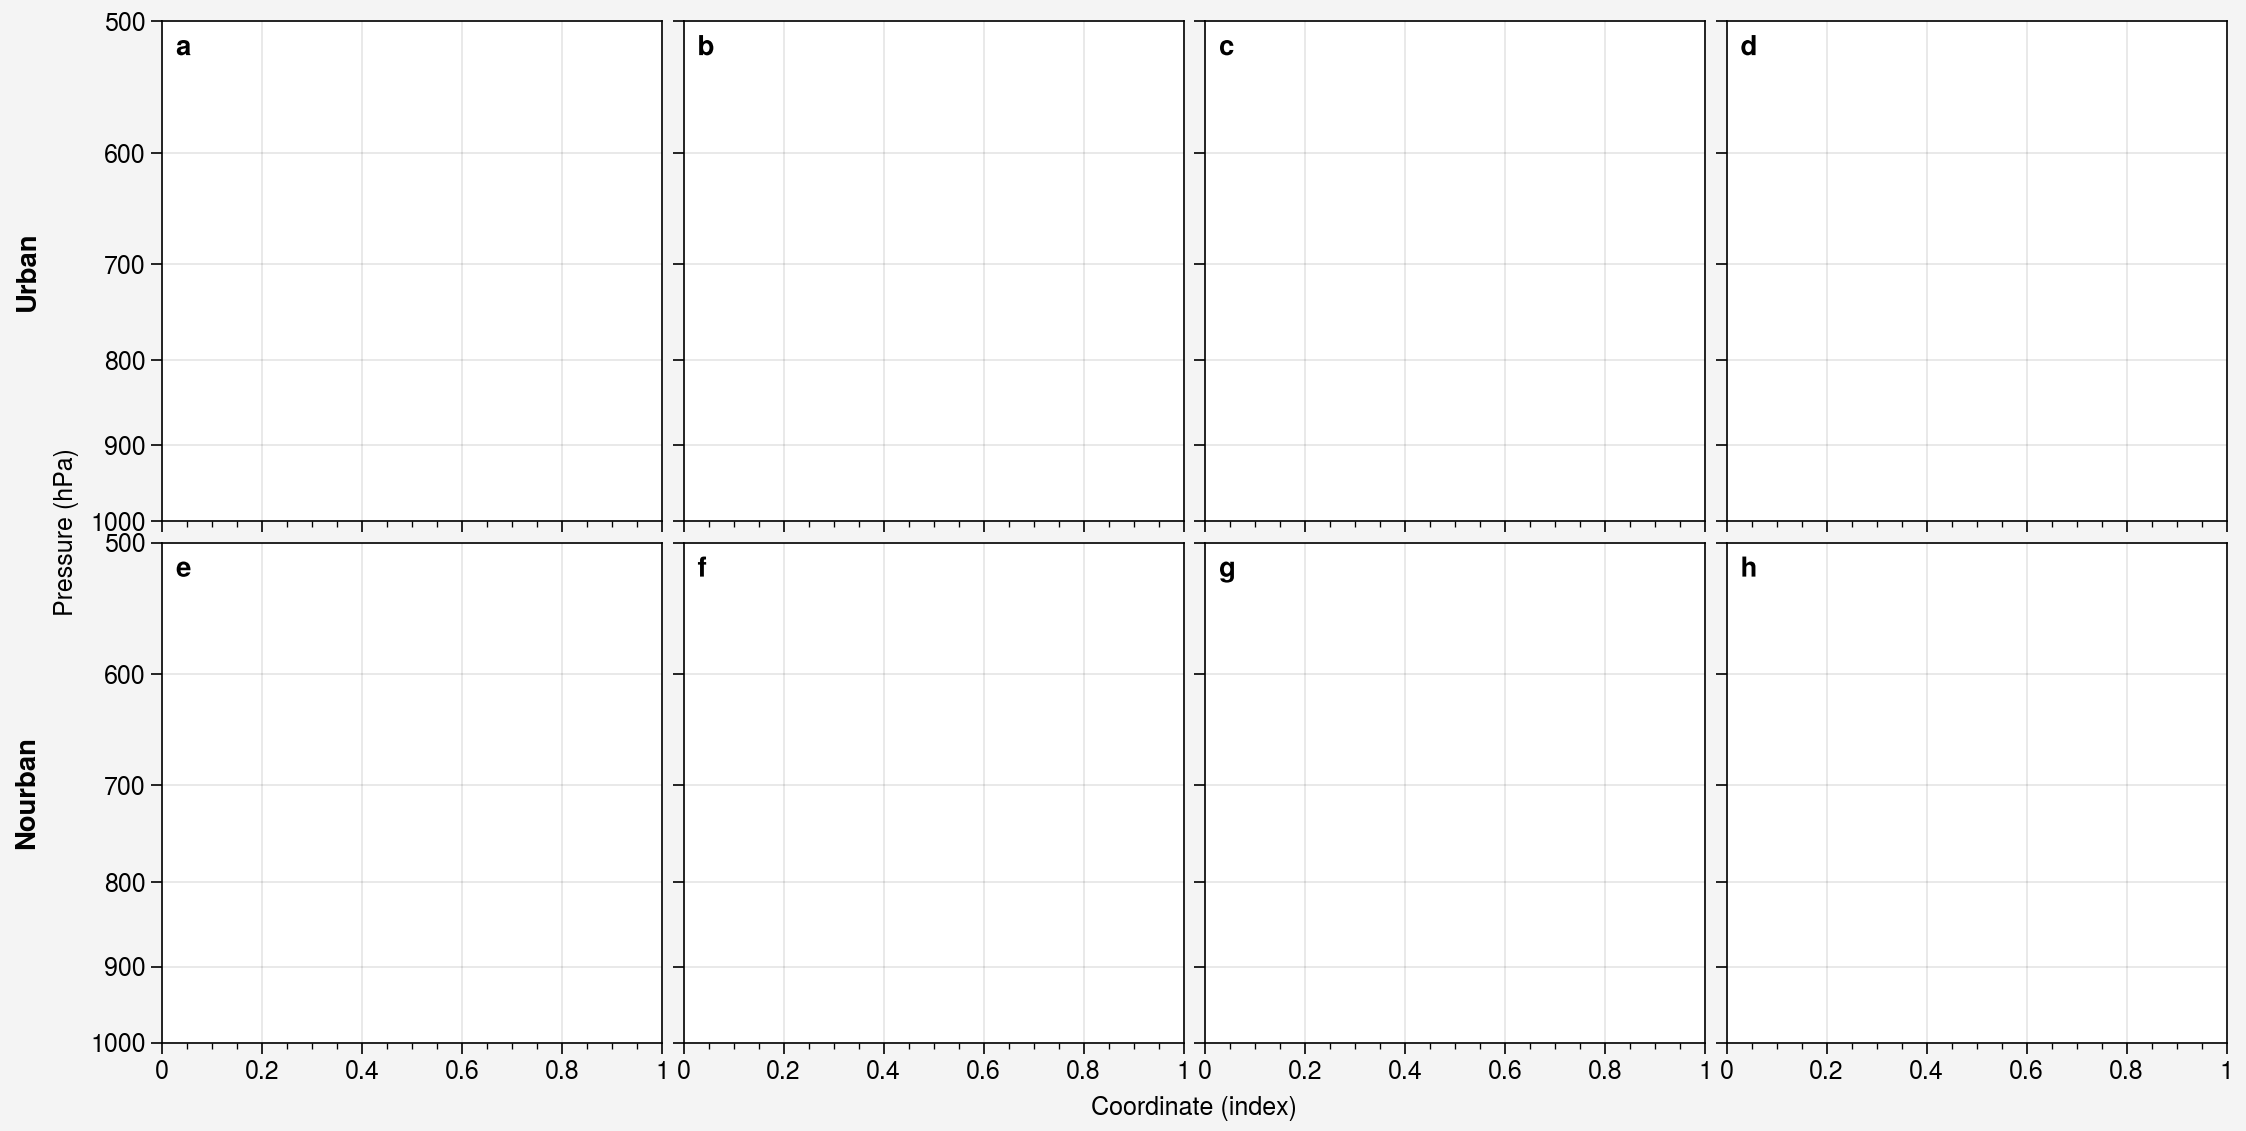

In [24]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            
                            includepanels=True,
                            hspace=0.86,
                            wspace=0.86,
                            sharey=3)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

axs.format(rowlabels=['Urban', 'Nourban'],
           #collabels=['11UTC', '12UTC', '13UTC', '14UTC']
           )

axs.format(ylim=(1000, 500), yscale='log',
           ylabel='Pressure (hPa)', ylocator=100,
           xlabel='Coordinate (index)')

x_fill = [20, 30, 40, 50]
y_fill = [800, 800, 800, 800]

for t in range(graphic_no):
    
    if t < graphic_no/2:
        dt_ens = dt_qv_era5_urban_ens*1000 # to g/kg
        dt_ens_wa = dt_avo_era5_urban_ens
        
        i = t
    else:
        dt_ens = dt_qv_era5_nourban_ens*1000 # to g/kg
        dt_ens_wa = dt_avo_era5_nourban_ens
        
        i = t-int(graphic_no/2)
        
    cut = -0.05
    mesh = axs[t].contourf(dt_ens[i]['cross_line_idx'], 
                    dt_ens[i]['vertical'],#[::-1],
                    dt_ens[i], 
                    cmap = cmap,
                    cmap_kw={'cut': cut},
                    linewidth = 0.1,
                    norm=norm,
                    zorder = 0.2,
                    alpha=1)
    
    
    axs[t].set_facecolor("#c1914d")
    
    if t < graphic_no/2:
        axs[t].fill_between(x_fill, 1000, y_fill,
                            interpolate=True, zorder=0.1,
                            color='#8f8e8c', hatch="///",
                            edgecolor="k", lw=0.3)
    
    # bottom hgt line
    axs[t].plot(range(len(dt_ens['cross_line_idx'])),
                 bottom_hgt_list,
                 color='k',
                 lw=0.4)
    
# colorbar
cbar = fig.colorbar(mesh,
                    label='g/kg',
                    ticks = ticks,
                    loc = 'b',
                    shrink = 0.3,
                    width = 0.15
                    #col=2
                   )

#save figure
#plt.savefig(r'pictures/era5_cs_qvapor_hourly.jpeg',
#            bbox_inches='tight', optimize=True,
#            progressive=True, dpi=1000)

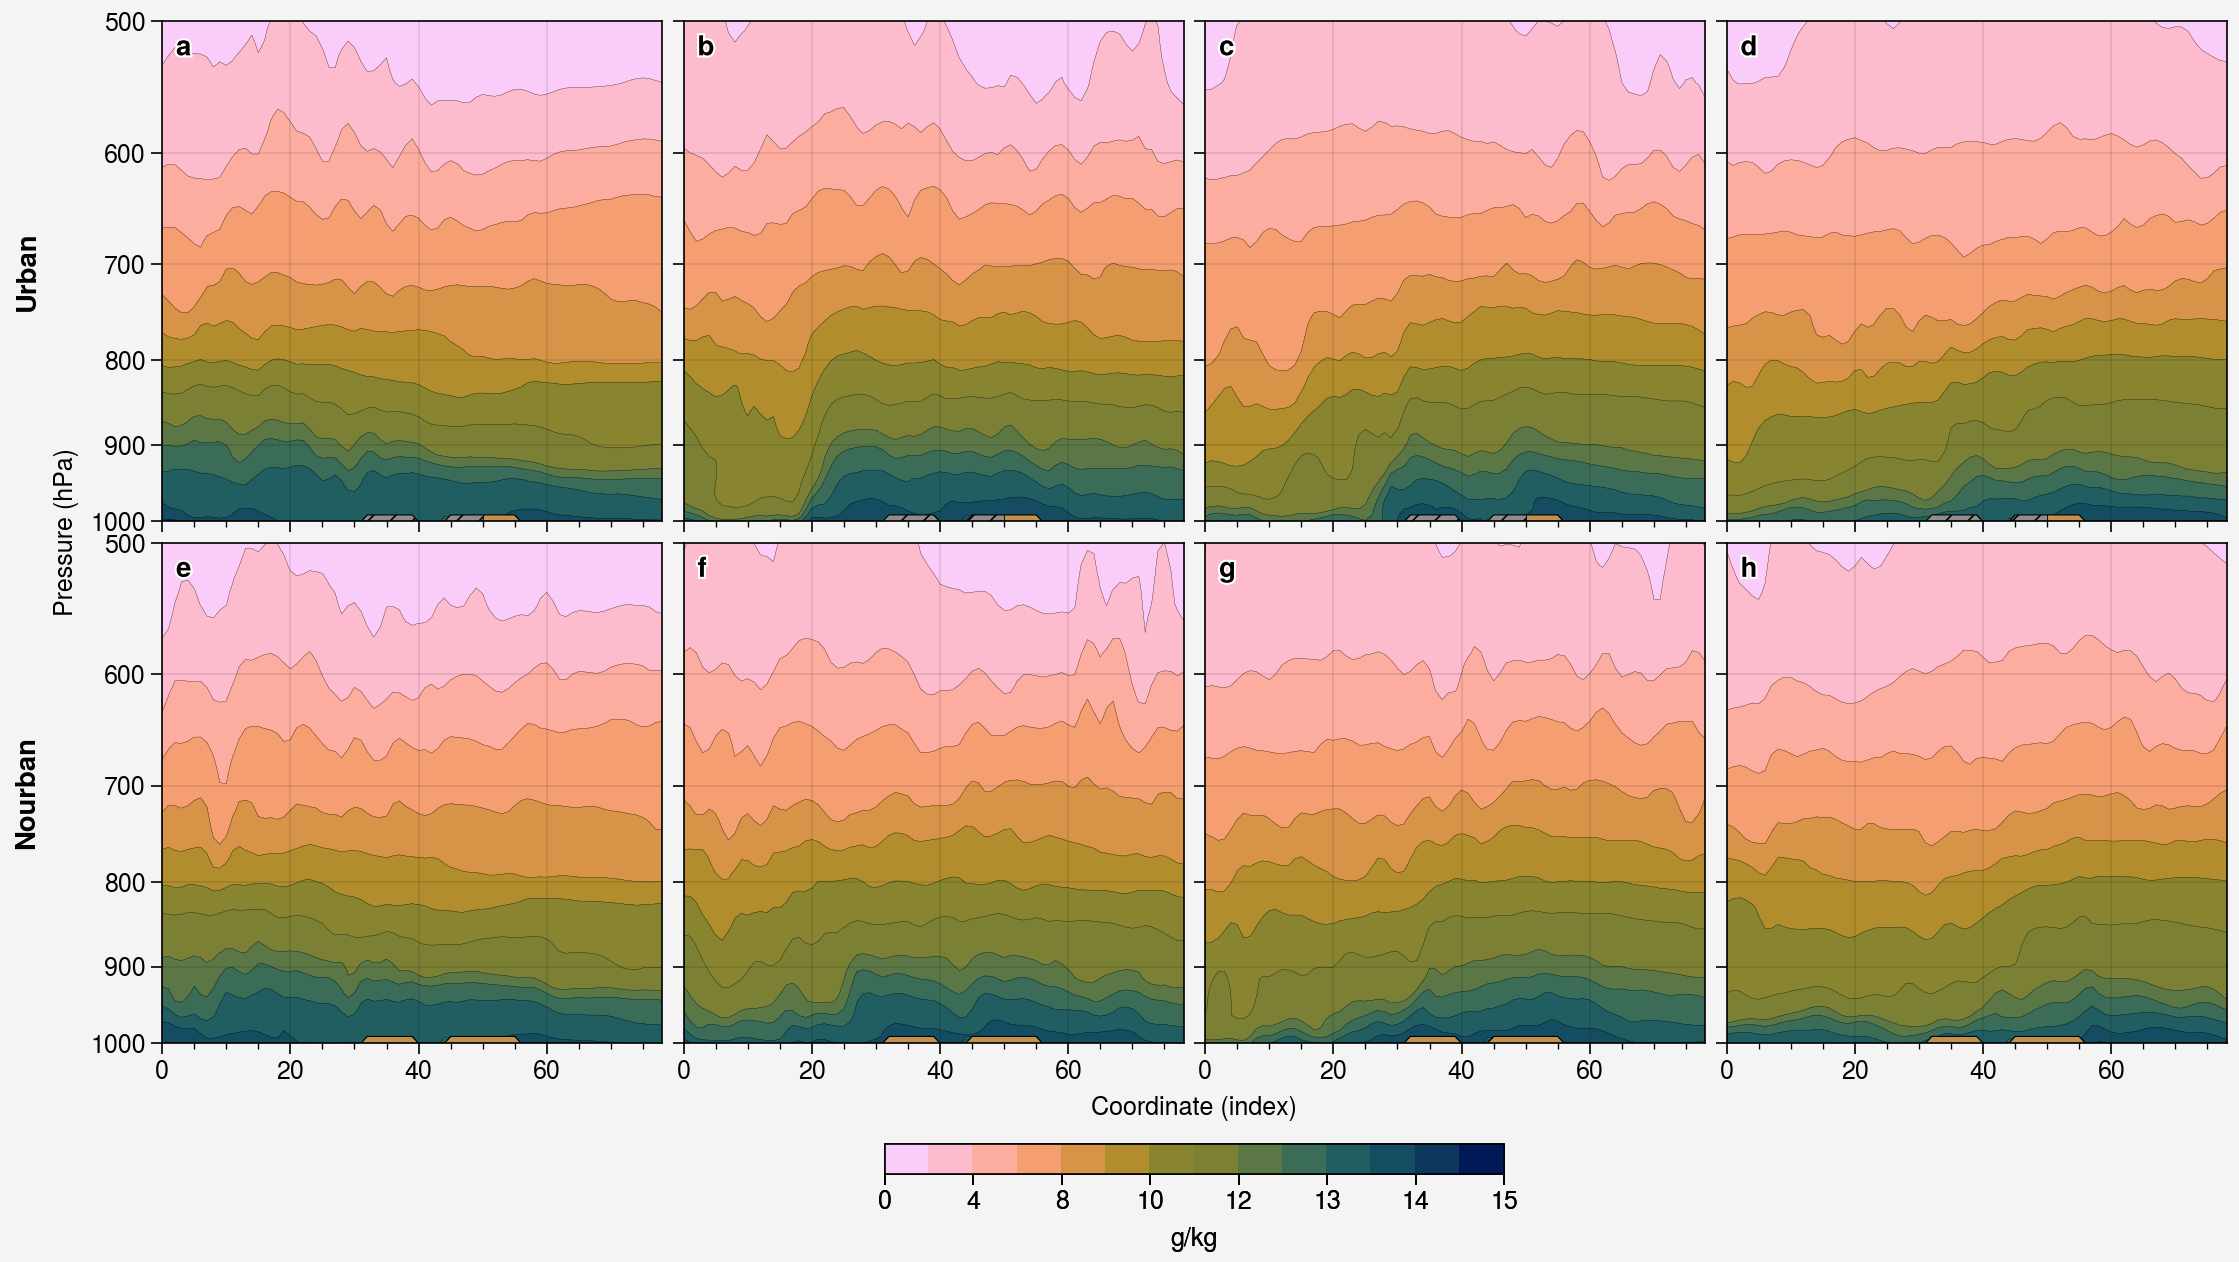

In [25]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            
                            includepanels=True,
                            hspace=0.86,
                            wspace=0.86,
                            sharey=3)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

axs.format(rowlabels=['Urban', 'Nourban'],
           #collabels=['11UTC', '12UTC', '13UTC', '14UTC']
           )

axs.format(ylim=(1000, 500), yscale='log',
           ylabel='Pressure (hPa)', ylocator=100,
           xlabel='Coordinate (index)')

x_fill = [20, 30, 40, 50]
y_fill = [800, 800, 800, 800]

for t in range(graphic_no):
    
    if t < graphic_no/2:
        dt_ens = dt_qv_era5_urban_ens*1000 # to g/kg
        #dt_ens_wa = dt_avo_era5_urban_ens
        
        i = t
    else:
        dt_ens = dt_qv_era5_nourban_ens*1000 # to g/kg
        #dt_ens_wa = dt_avo_era5_nourban_ens
        
        i = t-int(graphic_no/2)
        
    cut = -0.05
    mesh = axs[t].contourf(dt_ens[i]['cross_line_idx'], 
                    dt_ens[i]['vertical'],#[::-1],
                    dt_ens[i], 
                    cmap = cmap,
                    cmap_kw={'cut': cut},
                    linewidth = 0.1,
                    norm=norm,
                    zorder = 0.2,
                    alpha=1)
    
    
    axs[t].set_facecolor("#c1914d")
    
    if t < graphic_no/2:
        axs[t].fill_between(x_fill, 1000, y_fill,
                            interpolate=True, zorder=0.1,
                            color='#8f8e8c', hatch="///",
                            edgecolor="k", lw=0.3)
    
    # bottom hgt line
    axs[t].plot(range(len(dt_ens['cross_line_idx'])),
                 bottom_hgt_list,
                 color='k',
                 lw=0.4)
    
# colorbar
cbar = fig.colorbar(mesh,
                    label='g/kg',
                    ticks = ticks,
                    loc = 'b',
                    shrink = 0.3,
                    width = 0.15
                    #col=2
                   )

#save figure
#plt.savefig(r'pictures/era5_cs_qvapor_hourly.jpeg',
#            bbox_inches='tight', optimize=True,
#            progressive=True, dpi=1000)

## 3. One-Hour Prior to Precipitation Figure

In [12]:
# fig features
fig_array = [[1,2,3,4],
             [5,6,7,8],
            ]
graphic_no = 8

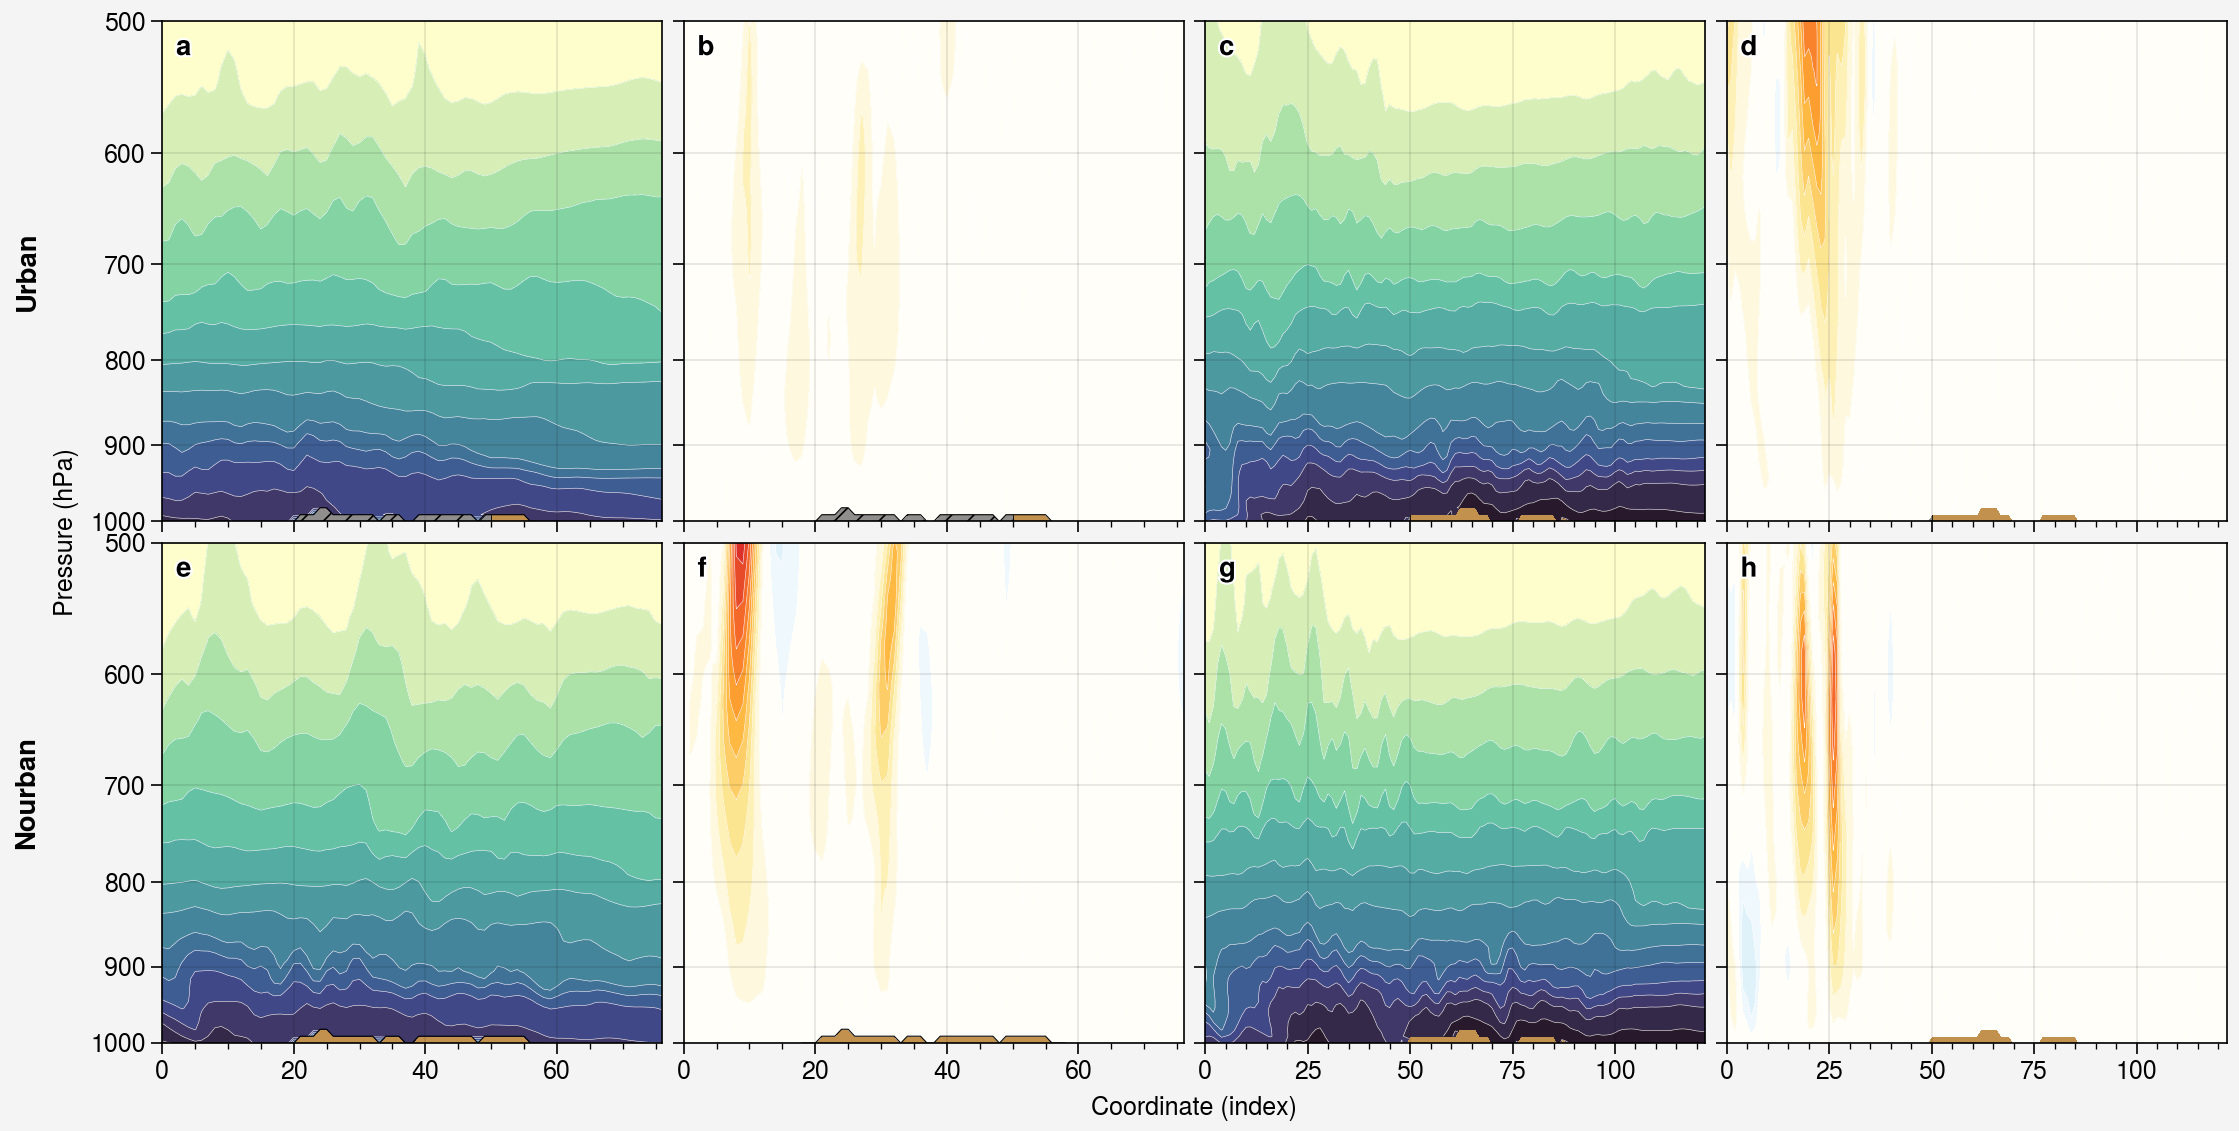

In [13]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            
                            includepanels=True,
                            hspace=0.86,
                            wspace=0.86,
                            sharey=3)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

axs.format(rowlabels=['Urban', 'Nourban'],
           #collabels=['11UTC', '12UTC', '13UTC', '14UTC']
           )

axs.format(ylim=(1000, 500), yscale='log',
           ylabel='Pressure (hPa)', ylocator=100,
           xlabel='Coordinate (index)')

x_fill = [20, 30, 40, 50]
y_fill = [800, 800, 800, 800]

for t in range(graphic_no):
    
    axs[t].set_facecolor("#c1914d")
    
    if t < graphic_no/2:
        axs[t].fill_between(x_fill, 1000, y_fill,
                            interpolate=True, zorder=0.1,
                            color='#8f8e8c', hatch="///",
                            edgecolor="k", lw=0.3)

# a and e options
for t in [0, 4]:
    if t == 0:
        dt_ens = dt_qv_era5_urban_ens*1000 # to g/kg
    else:
        dt_ens = dt_qv_era5_nourban_ens*1000 # to g/kg
        
    # figure features
    cmap_a_e = proplot.Colormap('deep')
    clevs_total_a_e = np.array([0,2,4,6,8,9,10,11,12,12.5,13,13.5,14,14.5,15])
    norm = BoundaryNorm(clevs_total_a_e,
                        ncolors=cmap_a_e.N, 
                        clip=True)
    ticks_a_e = np.array([0,4,8,10,12,13,14,15])
    cut = -0.05
    mesh_a_e = axs[t].contourf(dt_ens[0]['cross_line_idx'], 
                    dt_ens[0]['vertical'],#[::-1],
                    dt_ens[0], 
                    cmap = cmap_a_e,
                    #cmap_kw={'cut': cut},
                    linewidth = 0.2,
                    edgecolor='white',
                    norm=norm,
                    zorder = 0.2,
                    alpha=1)
    
# b and f options
for t in [1, 5]:
    if t == 1:
        dt_ens = dt_wa_era5_urban_ens 
    else:
        dt_ens = dt_wa_era5_nourban_ens 
        
    # figure features
    cmap_b_f = proplot.Colormap('ColdHot')
    clevs_total_b_f = np.arange(-14, 14.1, 1)
    norm = BoundaryNorm(clevs_total_b_f,
                        ncolors=cmap_b_f.N, 
                        clip=True)
    ticks_b_f = np.arange(-14, 14.1, 14)
    cut = -0.05
    
    mesh_b_f = axs[t].contourf(dt_ens[0]['cross_line_idx'], 
                    dt_ens[0]['vertical'],#[::-1],
                    dt_ens[0], 
                    cmap = cmap_b_f,
                    cmap_kw={'cut': cut},
                    linewidth = 0.2,
                    edgecolor='white',
                    norm=norm,
                    zorder = 0.2,
                    alpha=1)
    
# c and g options
time_cs2 = 1
for t in [2, 6]:
    if t == 2:
        dt_ens = dt_qv_era5_urban_ens_cs2*1000 # to g/kg
    else:
        dt_ens = dt_qv_era5_nourban_ens_cs2*1000 # to g/kg
        
    # figure features
    cmap_c_g = proplot.Colormap('deep')
    clevs_total_c_g = np.array([0,2,4,6,8,9,10,11,12,12.5,13,13.5,14,14.5,15])
    norm = BoundaryNorm(clevs_total_c_g,
                        ncolors=cmap_c_g.N, 
                        clip=True)
    ticks_c_g = np.array([0,4,8,10,12,13,14,15])
    cut = -0.05
    mesh_c_g = axs[t].contourf(dt_ens[time_cs2]['cross_line_idx'], 
                    dt_ens[time_cs2]['vertical'],#[::-1],
                    dt_ens[time_cs2], 
                    cmap = cmap_c_g,
                    #cmap_kw={'cut': cut},
                    linewidth = 0.2,
                    edgecolor='white',
                    norm=norm,
                    zorder = 0.2,
                    alpha=1)
    
# d and h options
for t in [3, 7]:
    if t == 3:
        dt_ens = dt_wa_era5_urban_ens_cs2 
    else:
        dt_ens = dt_wa_era5_nourban_ens_cs2 
        
    # figure features
    cmap_d_h = proplot.Colormap('ColdHot')
    clevs_total_d_h = np.arange(-14, 14.1, 1)
    norm = BoundaryNorm(clevs_total_d_h,
                        ncolors=cmap_d_h.N, 
                        clip=True)
    ticks_d_h = np.arange(-14, 14.1, 14)
    cut = -0.05
    
    mesh_d_h = axs[t].contourf(dt_ens[time_cs2]['cross_line_idx'], 
                    dt_ens[time_cs2]['vertical'],#[::-1],
                    dt_ens[time_cs2], 
                    cmap = cmap_d_h,
                    cmap_kw={'cut': cut},
                    linewidth = 0.2,
                    edgecolor='white',
                    norm=norm,
                    zorder = 0.2,
                    alpha=1)
    
for t in range(graphic_no):
    
    # bottom hgt line
    if t in [0,1,4,5]:
        axs[t].plot(range(len(dt_tempor['cross_line_idx'])),
                     bottom_hgt_list,
                     color='k',
                     lw=0.4)
    # bottom hgt line
    #if t in [2,3,6,7]:
    #    axs[t].plot(range(len(dt_tempor_cs2['cross_line_idx'])),
    #                 bottom_hgt_list_cs2,
    #                 color='k',
    #                 lw=0.4)